### How to use **`estimate()`**

In [1]:
import math
import time
import ffsim
from passive_extended_matchgate_simulator.raw_estimation import raw_estimate
from passive_extended_matchgate_simulator.estimation import estimate
from passive_extended_matchgate_simulator.utils import ucj_to_compatible
from passive_extended_matchgate_simulator.exact import exact_calculation
from qiskit.circuit import QuantumCircuit, QuantumRegister

#### We'll create a circuit that has 12 qubits and 16 controlled-phase gates. Our matchgates will be initialized randomly, but our controlled-phase gate angles will be sampled from  $\sim \mathcal{N}(0, .1)$.

In [2]:
mean, var = 0, .1
norb, nelec = 6, (3,3)

alpha_alpha_indices = [(p, p + 1) for p in range(norb - 1)]
alpha_beta_indices = [(p, p) for p in range(norb)]

qubits = QuantumRegister(2 * norb)
circuit = QuantumCircuit(qubits)
scale = math.sqrt(var)
ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb,
                                                interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
                                                with_final_orbital_rotation=False,
                                                diag_coulomb_mean=mean,
                                                diag_coulomb_scale=scale,
                                                diag_coulomb_normal=True)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

#### We will run this helper function to 1) get rid of any unnecessary global phase gates and 2) make sure that the X gates described by the hartree_fock_jw gate remain at the beginning of the circuit. 

In [3]:
compatible = ucj_to_compatible(circuit)

#### Here is what the circuit looks like when it was been decomposed into just matchgates and controlled-phase gates.

Our circuit contains the following gates:
OrderedDict({'xx_plus_yy': 60, 'p': 24, 'cp': 16, 'x': 6})


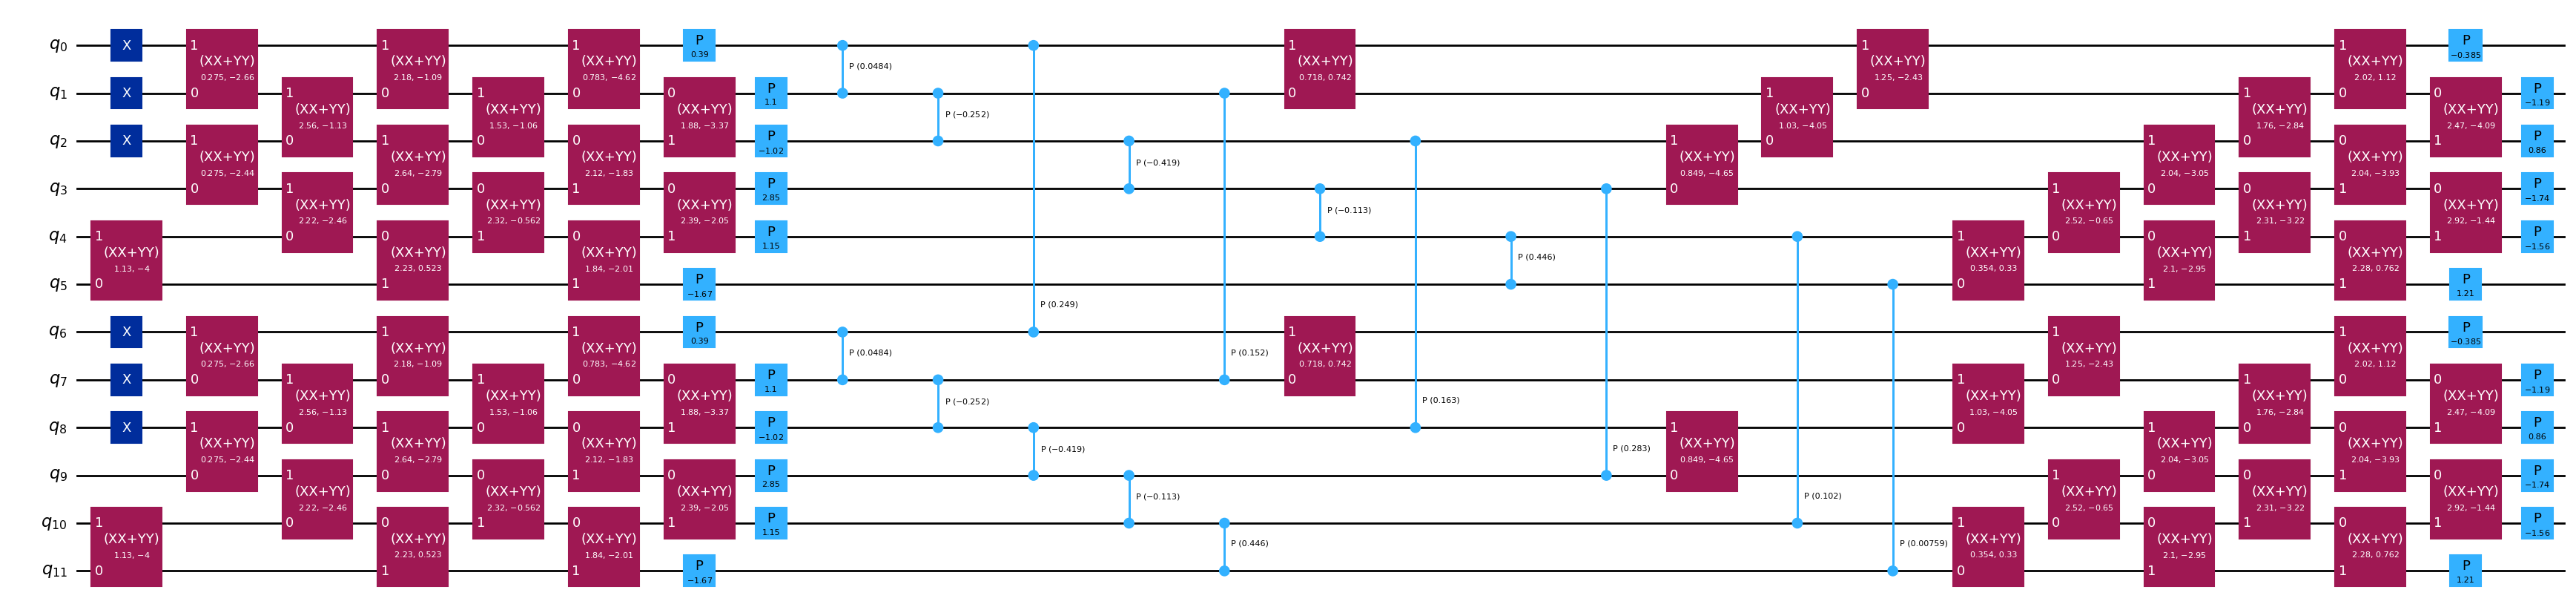

In [4]:
print("Our circuit contains the following gates:")
print(compatible.decompose(gates_to_decompose=['orb_rot_jw']).count_ops())
compatible.decompose(gates_to_decompose=['orb_rot_jw']).draw(fold=-1, output='mpl')

#### Let's compare how long it takes to obtain a probability estimate with **`estimate()`** vs **`raw_estimate()`** for small values of $\epsilon$ and $\delta$. We'll estimate the probability of bitstring 111000111000, which we expect to be small.

In [5]:
epsilon, delta, p = .01, .00001, 1
bitstring = 0b111000111000

In [6]:
t1 = time.perf_counter()
raw_est = raw_estimate(circuit=compatible,
                   outcome_states=bitstring,
                   epsilon=epsilon,
                   delta=delta,
                   p=p)
t2 = time.perf_counter()
raw_est_time = t2 - t1
print("Raw estimate probability:", raw_est)
print(f"Raw estimate time: {raw_est_time} seconds")

Raw estimate probability: 7.198745692992628e-09
Raw estimate time: 5.211401917040348 seconds


In [7]:
t1 = time.perf_counter()
est = estimate(circuit=compatible,
               outcome_state=bitstring,
               epsilon=epsilon,
               delta=delta)
t2 = time.perf_counter()
est_time = t2 - t1
time.sleep(1)
print()
print("Estimate probability:", est)
print(f"Estimate time: {est_time} seconds")
print(f"Estimate speedup over raw_estimate: {raw_est_time / est_time}x")

k: 1, pHat: 0.00000009113320720205262, eStar: 0.9999518652535255, epsTot: 0.01
k: 2, pHat: 0.000000035167745275365245, eStar: 0.7065999628960435, epsTot: 0.01
k: 3, pHat: 0.000000003476824765130878, eStar: 0.39958753343045605, epsTot: 0.01
k: 4, pHat: 0.000000011505423370121782, eStar: 0.19908097752083603, epsTot: 0.01
k: 5, pHat: 0.000000014686715249198272, eStar: 0.09366046803209135, epsTot: 0.01
k: 6, pHat: 0.000000006041195293862676, eStar: 0.043451977584637355, epsTot: 0.01
k: 7, pHat: 0.0000000056289559637988395, eStar: 0.020312607105996583, epsTot: 0.01
k: 8, pHat: 0.000000005749797773261097, eStar: 0.009638574093224706, epsTot: 0.01

Estimate probability: 5.749797773261097e-09
Estimate time: 0.20533041702583432 seconds
Estimate speedup over raw_estimate: 25.380564616418514x


#### Let's make sure that our estimate and raw estimate are close to the exact probability of the bitstring.

In [8]:
exact_probability = exact_calculation(circuit=compatible, outcome_states=bitstring)
print("The exact probability is:", exact_probability)
print("|raw_estimate - exact| =", abs(raw_est - exact_probability))
print("|estimate - exact| = ", abs(est - exact_probability))

The exact probability is: 7.2246393600318e-09
|raw_estimate - exact| = 2.5893667039172564e-11
|estimate - exact| =  1.4748415867707035e-09
